In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Model selection and evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_excel("Kickstarter.xlsx")

In [3]:
# Pre-Processing
df = df.dropna()
# list of categories to be saved
category_to_save = ['failed','successful']

# use not operator with isin()
df = df[df['state'].isin(category_to_save)]
df

,id,name,goal,pledged,state,disable_communication,country,currency,deadline,state_changed_at,...,created_at_day,created_at_yr,created_at_hr,launched_at_month,launched_at_day,launched_at_yr,launched_at_hr,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days
0,1538064060,MAGIC PIXEL - Bluetooth full color LED display,15000.0,5933.0,failed,False,GB,GBP,2016-03-19 09:31:29,2016-03-19 09:31:32,...,18,2015,3,2,18,2016,9,62,30,30
4,1315415013,help send Object Collection to Norway!,2000.0,2300.0,successful,False,US,USD,2016-03-03 17:00:00,2016-03-03 17:00:00,...,16,2016,10,2,18,2016,7,1,14,14
5,836821539,The Tragedy of Mario and Juliet,3000.0,3255.0,successful,False,US,USD,2016-04-18 04:13:25,2016-04-18 04:13:25,...,27,2016,17,2,18,2016,4,21,60,60
6,2077265745,Timepiece Pulu,35000.0,823.0,failed,False,US,USD,2016-03-25 21:46:51,2016-03-25 21:46:51,...,24,2016,23,2,17,2016,21,23,37,37
7,2119284588,Stikk- The Gel Pad That Will Stick Anything to...,2000.0,62831.0,successful,False,AU,AUD,2016-03-18 21:25:42,2016-03-18 21:25:42,...,16,2016,8,2,17,2016,21,1,30,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15467,798022664,Blow your Money so we can Blow your Mind.,1200.0,595.0,failed,False,US,USD,2009-07-14 15:43:00,2009-07-14 15:45:26,...,15,2009,15,5,15,2009,17,0,59,59
15469,2131090134,Tweetsourcing,2500.0,0.0,failed,False,US,USD,2009-07-14 10:57:00,2009-07-14 11:00:29,...,12,2009,10,5,12,2009,14,0,62,62
15470,824394828,iGoozex - Free iPhone app,250.0,6.0,failed,False,US,USD,2009-06-01 11:00:00,2009-06-01 11:00:28,...,7,2009,14,5,7,2009,17,0,24,24
15472,177921463,Icons for your iPhone apps,500.0,1820.0,successful,False,US,USD,2009-06-15 14:00:00,2009-06-15 14:00:31,...,29,2009,14,4,29,2009,16,0,46,46


In [4]:
# now check for missing value
# all variables has the same length
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12180 entries, 0 to 15473
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           12180 non-null  int64         
 1   name                         12180 non-null  object        
 2   goal                         12180 non-null  float64       
 3   pledged                      12180 non-null  float64       
 4   state                        12180 non-null  object        
 5   disable_communication        12180 non-null  bool          
 6   country                      12180 non-null  object        
 7   currency                     12180 non-null  object        
 8   deadline                     12180 non-null  datetime64[ns]
 9   state_changed_at             12180 non-null  datetime64[ns]
 10  created_at                   12180 non-null  datetime64[ns]
 11  launched_at                  12180 non-nu

# Feature Engineering

In [5]:
# Feature Classfifcation 
response = ['state']

categorical = ['disable_communication', 'country', 'currency', 
               'staff_pick', 'category', 'spotlight','deadline_weekday',
              'state_changed_at_weekday', 'created_at_weekday', 'launched_at_weekday']

continuous = ['goal', 'pledged', 'backers_count', 'static_usd_rate',
              'usd_pledged']
discreet = ['name_len','name_len_clean','blurb_len','blurb_len_clean',
           'deadline_month','deadline_day','deadline_yr','deadline_hr',
           'state_changed_at_hr','created_at_month','created_at_day',
           'created_at_hr','launched_at_month','launched_at_day',
           'launched_at_hr','create_to_launch_days','launch_to_deadline_days']

identifier = ['id','name']

date = ['deadline', 'state_changed_at', 'created_at', 'launched_at']

In [6]:
# checking categorical variable  
# exclude 'disable_communication' cuz it only has one value
for i in categorical:
    print(df[i].unique())

[False]
['GB' 'US' 'AU' 'CA' 'NO' 'FR' 'BE' 'NZ' 'IT' 'SE' 'IE' 'DK' 'ES' 'DE'
 'NL' 'CH' 'AT' 'LU']
['GBP' 'USD' 'AUD' 'CAD' 'NOK' 'EUR' 'NZD' 'SEK' 'DKK' 'CHF']
[False  True]
['Gadgets' 'Experimental' 'Plays' 'Spaces' 'Web' 'Apps' 'Wearables'
 'Software' 'Festivals' 'Hardware' 'Robots' 'Makerspaces' 'Musical'
 'Immersive' 'Flight' 'Sound' 'Academic' 'Places' 'Thrillers' 'Webseries'
 'Blues' 'Shorts']
[False  True]
['Saturday' 'Thursday' 'Monday' 'Friday' 'Sunday' 'Wednesday' 'Tuesday']
['Saturday' 'Thursday' 'Monday' 'Friday' 'Sunday' 'Wednesday' 'Tuesday']
['Friday' 'Tuesday' 'Wednesday' 'Sunday' 'Thursday' 'Monday' 'Saturday']
['Thursday' 'Wednesday' 'Tuesday' 'Monday' 'Sunday' 'Saturday' 'Friday']


In [7]:
# check relationship between date and its sub variable 
# since the sub variable can perfectly match the initial date, we dont need date variable anymore
df_date = df[['deadline','deadline_month','deadline_day','deadline_yr','deadline_hr','deadline_weekday']]
df_date

,deadline,deadline_month,deadline_day,deadline_yr,deadline_hr,deadline_weekday
0,2016-03-19 09:31:29,3,19,2016,9,Saturday
4,2016-03-03 17:00:00,3,3,2016,17,Thursday
5,2016-04-18 04:13:25,4,18,2016,4,Monday
6,2016-03-25 21:46:51,3,25,2016,21,Friday
7,2016-03-18 21:25:42,3,18,2016,21,Friday
...,...,...,...,...,...,...
15467,2009-07-14 15:43:00,7,14,2009,15,Tuesday
15469,2009-07-14 10:57:00,7,14,2009,10,Tuesday
15470,2009-06-01 11:00:00,6,1,2009,11,Monday
15472,2009-06-15 14:00:00,6,15,2009,14,Monday


In [8]:
# checking similar variable 
# potential colinearity between these two set of variables 
df[['name_len','name_len_clean','blurb_len','blurb_len_clean']].corr()

,name_len,name_len_clean,blurb_len,blurb_len_clean
name_len,1.000000,0.943829,0.155388,0.192716
name_len_clean,0.943829,1.000000,0.141336,0.211151
blurb_len,0.155388,0.141336,1.000000,0.777267
blurb_len_clean,0.192716,0.211151,0.777267,1.000000


In [9]:
# Tests for skewness of data, to determine whether to scale with median or mean
from scipy.stats import skewtest


skewed = []
non_skewed = []

for i in continuous+discreet:
    p = skewtest(df[i], nan_policy='omit')[1] # calculates skewtest p_value (H0 = normally distributed)
    if p < 0.01:
        skewed.append(i)
    else:
        non_skewed.append(i)
        
print('Skewed variables are:\n{0}\n\nNon-skewed variables are:\n{1}'.format(skewed, non_skewed))
# too much variables are skewed, probably need to standardize the predictors 

Skewed variables are:
['goal', 'pledged', 'backers_count', 'static_usd_rate', 'usd_pledged', 'name_len', 'name_len_clean', 'blurb_len', 'blurb_len_clean', 'deadline_month', 'deadline_yr', 'deadline_hr', 'state_changed_at_hr', 'created_at_hr', 'launched_at_month', 'launched_at_day', 'launched_at_hr', 'create_to_launch_days', 'launch_to_deadline_days']

Non-skewed variables are:
['deadline_day', 'created_at_month', 'created_at_day']


In [10]:
# drop some variables 
# will come back to 'name_len','name_len_clean','blurb_len','blurb_len_clean' later
DeleteList = identifier + date + ['disable_communication','staff_pick','spotlight','currency',
                                  'state_changed_at_weekday','launch_to_state_change_days',
                                  'state_changed_at_month','state_changed_at_yr',
                                  'state_changed_at_day','launched_at_yr','created_at_yr',
                                  'state_changed_at_hr','pledged','usd_pledged','backers_count',
                                 'name_len','blurb_len'] 
df = df.drop(DeleteList, axis=1)
df
# now we reduce to 24 predictors 

,goal,state,country,static_usd_rate,category,name_len_clean,blurb_len_clean,deadline_weekday,created_at_weekday,launched_at_weekday,...,deadline_yr,deadline_hr,created_at_month,created_at_day,created_at_hr,launched_at_month,launched_at_day,launched_at_hr,create_to_launch_days,launch_to_deadline_days
0,15000.0,failed,GB,1.429989,Gadgets,8.0,14.0,Saturday,Friday,Thursday,...,2016,9,12,18,3,2,18,9,62,30
4,2000.0,successful,US,1.000000,Experimental,5.0,13.0,Thursday,Tuesday,Thursday,...,2016,17,2,16,10,2,18,7,1,14
5,3000.0,successful,US,1.000000,Plays,4.0,14.0,Monday,Wednesday,Thursday,...,2016,4,1,27,17,2,18,4,21,60
6,35000.0,failed,US,1.000000,Gadgets,2.0,15.0,Friday,Sunday,Wednesday,...,2016,21,1,24,23,2,17,21,23,37
7,2000.0,successful,AU,0.710177,Gadgets,9.0,12.0,Friday,Tuesday,Wednesday,...,2016,21,2,16,8,2,17,21,1,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15467,1200.0,failed,US,1.000000,Software,4.0,4.0,Tuesday,Friday,Friday,...,2009,15,5,15,15,5,15,17,0,59
15469,2500.0,failed,US,1.000000,Software,1.0,15.0,Tuesday,Tuesday,Tuesday,...,2009,10,5,12,10,5,12,14,0,62
15470,250.0,failed,US,1.000000,Software,5.0,15.0,Monday,Thursday,Thursday,...,2009,11,5,7,14,5,7,17,0,24
15472,500.0,successful,US,1.000000,Software,3.0,15.0,Monday,Wednesday,Wednesday,...,2009,14,4,29,14,4,29,16,0,46


In [11]:
categorical = ['country', 'category','deadline_weekday', 'created_at_weekday', 'launched_at_weekday']
df = pd.get_dummies(df, columns=response+categorical, drop_first=True)
df = df.drop('country_LU', axis=1)

In [12]:
pd.set_option('display.max_columns', None)
df.head()

,goal,static_usd_rate,name_len_clean,blurb_len_clean,deadline_month,deadline_day,deadline_yr,deadline_hr,created_at_month,created_at_day,created_at_hr,launched_at_month,launched_at_day,launched_at_hr,create_to_launch_days,launch_to_deadline_days,state_successful,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_IE,country_IT,country_NL,country_NO,country_NZ,country_SE,country_US,category_Apps,category_Blues,category_Experimental,category_Festivals,category_Flight,category_Gadgets,category_Hardware,category_Immersive,category_Makerspaces,category_Musical,category_Places,category_Plays,category_Robots,category_Shorts,category_Software,category_Sound,category_Spaces,category_Thrillers,category_Wearables,category_Web,category_Webseries,deadline_weekday_Monday,deadline_weekday_Saturday,deadline_weekday_Sunday,deadline_weekday_Thursday,deadline_weekday_Tuesday,deadline_weekday_Wednesday,created_at_weekday_Monday,created_at_weekday_Saturday,created_at_weekday_Sunday,created_at_weekday_Thursday,created_at_weekday_Tuesday,created_at_weekday_Wednesday,launched_at_weekday_Monday,launched_at_weekday_Saturday,launched_at_weekday_Sunday,launched_at_weekday_Thursday,launched_at_weekday_Tuesday,launched_at_weekday_Wednesday
0,15000.0,1.429989,8.0,14.0,3,19,2016,9,12,18,3,2,18,9,62,30,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,2000.0,1.000000,5.0,13.0,3,3,2016,17,2,16,10,2,18,7,1,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
5,3000.0,1.000000,4.0,14.0,4,18,2016,4,1,27,17,2,18,4,21,60,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
6,35000.0,1.000000,2.0,15.0,3,25,2016,21,1,24,23,2,17,21,23,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
7,2000.0,0.710177,9.0,12.0,3,18,2016,21,2,16,8,2,17,21,1,30,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [13]:
X = df.drop('state_successful', axis=1)
X

,goal,static_usd_rate,name_len_clean,blurb_len_clean,deadline_month,deadline_day,deadline_yr,deadline_hr,created_at_month,created_at_day,created_at_hr,launched_at_month,launched_at_day,launched_at_hr,create_to_launch_days,launch_to_deadline_days,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_IE,country_IT,country_NL,country_NO,country_NZ,country_SE,country_US,category_Apps,category_Blues,category_Experimental,category_Festivals,category_Flight,category_Gadgets,category_Hardware,category_Immersive,category_Makerspaces,category_Musical,category_Places,category_Plays,category_Robots,category_Shorts,category_Software,category_Sound,category_Spaces,category_Thrillers,category_Wearables,category_Web,category_Webseries,deadline_weekday_Monday,deadline_weekday_Saturday,deadline_weekday_Sunday,deadline_weekday_Thursday,deadline_weekday_Tuesday,deadline_weekday_Wednesday,created_at_weekday_Monday,created_at_weekday_Saturday,created_at_weekday_Sunday,created_at_weekday_Thursday,created_at_weekday_Tuesday,created_at_weekday_Wednesday,launched_at_weekday_Monday,launched_at_weekday_Saturday,launched_at_weekday_Sunday,launched_at_weekday_Thursday,launched_at_weekday_Tuesday,launched_at_weekday_Wednesday
0,15000.0,1.429989,8.0,14.0,3,19,2016,9,12,18,3,2,18,9,62,30,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,2000.0,1.000000,5.0,13.0,3,3,2016,17,2,16,10,2,18,7,1,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
5,3000.0,1.000000,4.0,14.0,4,18,2016,4,1,27,17,2,18,4,21,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
6,35000.0,1.000000,2.0,15.0,3,25,2016,21,1,24,23,2,17,21,23,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
7,2000.0,0.710177,9.0,12.0,3,18,2016,21,2,16,8,2,17,21,1,30,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15467,1200.0,1.000000,4.0,4.0,7,14,2009,15,5,15,15,5,15,17,0,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
15469,2500.0,1.000000,1.0,15.0,7,14,2009,10,5,12,10,5,12,14,0,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
15470,250.0,1.000000,5.0,15.0,6,1,2009,11,5,7,14,5,7,17,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
15472,500.0,1.000000,3.0,15.0,6,15,2009,14,4,29,14,4,29,16,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
pd.set_option('display.max_rows', vif_data.shape[0]+1)  
vif_data.sort_values('VIF',ascending=False)
# perfection correlation between country and currency, 


,feature,VIF
6,deadline_yr,2306.077214
1,static_usd_rate,838.115667
31,country_US,420.588612
38,category_Hardware,157.835430
51,category_Web,144.687207
46,category_Software,123.472297
24,country_GB,95.634792
37,category_Gadgets,84.214946
43,category_Plays,56.350139
32,category_Apps,50.618392


# Model Building

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, df['state_successful'],test_size=.33, random_state=5)

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
lr_list = [0.01, 0.05, 0.075, 0.1, 0.25,0.33,0.5,0.75,0.9,1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(learning_rate=learning_rate, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Learning rate:  0.01
Accuracy score (training): 0.681
Accuracy score (validation): 0.680
Learning rate:  0.05
Accuracy score (training): 0.764
Accuracy score (validation): 0.746
Learning rate:  0.075
Accuracy score (training): 0.774
Accuracy score (validation): 0.747
Learning rate:  0.1
Accuracy score (training): 0.781
Accuracy score (validation): 0.752
Learning rate:  0.25
Accuracy score (training): 0.808
Accuracy score (validation): 0.747
Learning rate:  0.33
Accuracy score (training): 0.817
Accuracy score (validation): 0.750
Learning rate:  0.5
Accuracy score (training): 0.836
Accuracy score (validation): 0.737
Learning rate:  0.75
Accuracy score (training): 0.859
Accuracy score (validation): 0.730
Learning rate:  0.9
Accuracy score (training): 0.868
Accuracy score (validation): 0.725
Learning rate:  1
Accuracy score (training): 0.869
Accuracy score (validation): 0.726


# Results

In [17]:
gb_clf2 = GradientBoostingClassifier(learning_rate=0.1, random_state=0)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[2344  368]
 [ 627  681]]
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      2712
           1       0.65      0.52      0.58      1308

    accuracy                           0.75      4020
   macro avg       0.72      0.69      0.70      4020
weighted avg       0.74      0.75      0.74      4020



In [18]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 500, 1000, 10000]

for estimators in n_estimators:
    gb_clf = GradientBoostingClassifier(n_estimators= estimators, learning_rate= 0.1, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Number of estimator: ", estimators)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Number of estimator:  1
Accuracy score (training): 0.675
Accuracy score (validation): 0.675
Number of estimator:  2
Accuracy score (training): 0.675
Accuracy score (validation): 0.675
Number of estimator:  4
Accuracy score (training): 0.675
Accuracy score (validation): 0.675
Number of estimator:  8
Accuracy score (training): 0.675
Accuracy score (validation): 0.674
Number of estimator:  16
Accuracy score (training): 0.733
Accuracy score (validation): 0.730
Number of estimator:  32
Accuracy score (training): 0.756
Accuracy score (validation): 0.741
Number of estimator:  64
Accuracy score (training): 0.769
Accuracy score (validation): 0.751
Number of estimator:  100
Accuracy score (training): 0.781
Accuracy score (validation): 0.752
Number of estimator:  200
Accuracy score (training): 0.799
Accuracy score (validation): 0.748
Number of estimator:  500
Accuracy score (training): 0.837
Accuracy score (validation): 0.747
Number of estimator:  1000
Accuracy score (training): 0.891
Accuracy sc

In [19]:
gb_clf2 = GradientBoostingClassifier(n_estimators= 100, learning_rate=0.1, random_state=0)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[2344  368]
 [ 627  681]]
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      2712
           1       0.65      0.52      0.58      1308

    accuracy                           0.75      4020
   macro avg       0.72      0.69      0.70      4020
weighted avg       0.74      0.75      0.74      4020



In [20]:
max_depth = range(1,10,1)

for depth in max_depth:
    gb_clf = GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.1, max_depth= depth, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Maximum of depth: ", depth)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Maximum of depth:  1
Accuracy score (training): 0.740
Accuracy score (validation): 0.732
Maximum of depth:  2
Accuracy score (training): 0.763
Accuracy score (validation): 0.748
Maximum of depth:  3
Accuracy score (training): 0.781
Accuracy score (validation): 0.752
Maximum of depth:  4
Accuracy score (training): 0.805
Accuracy score (validation): 0.750
Maximum of depth:  5
Accuracy score (training): 0.834
Accuracy score (validation): 0.750
Maximum of depth:  6
Accuracy score (training): 0.876
Accuracy score (validation): 0.748
Maximum of depth:  7
Accuracy score (training): 0.921
Accuracy score (validation): 0.750
Maximum of depth:  8
Accuracy score (training): 0.963
Accuracy score (validation): 0.745
Maximum of depth:  9
Accuracy score (training): 0.991
Accuracy score (validation): 0.748


In [21]:
gb_clf2 = GradientBoostingClassifier(n_estimators= 100, learning_rate=0.1,max_depth=3, random_state=0)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[2344  368]
 [ 627  681]]
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      2712
           1       0.65      0.52      0.58      1308

    accuracy                           0.75      4020
   macro avg       0.72      0.69      0.70      4020
weighted avg       0.74      0.75      0.74      4020



In [22]:
max_features = range(1,X_train.shape[1])

for features in max_features:
    gb_clf = GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.1, max_features= features, max_depth= 3, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Maximum of features: ", features)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Maximum of features:  1
Accuracy score (training): 0.731
Accuracy score (validation): 0.727
Maximum of features:  2
Accuracy score (training): 0.738
Accuracy score (validation): 0.725
Maximum of features:  3
Accuracy score (training): 0.760
Accuracy score (validation): 0.739
Maximum of features:  4
Accuracy score (training): 0.759
Accuracy score (validation): 0.740
Maximum of features:  5
Accuracy score (training): 0.762
Accuracy score (validation): 0.741
Maximum of features:  6
Accuracy score (training): 0.767
Accuracy score (validation): 0.749
Maximum of features:  7
Accuracy score (training): 0.770
Accuracy score (validation): 0.746
Maximum of features:  8
Accuracy score (training): 0.770
Accuracy score (validation): 0.752
Maximum of features:  9
Accuracy score (training): 0.774
Accuracy score (validation): 0.749
Maximum of features:  10
Accuracy score (training): 0.774
Accuracy score (validation): 0.753
Maximum of features:  11
Accuracy score (training): 0.772
Accuracy score (valid

In [24]:
gb_clf2 = GradientBoostingClassifier(n_estimators= 100, learning_rate=0.1, max_features=10, 
                                     max_depth=3, random_state=0)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[2374  338]
 [ 656  652]]
Classification Report
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      2712
           1       0.66      0.50      0.57      1308

    accuracy                           0.75      4020
   macro avg       0.72      0.69      0.70      4020
weighted avg       0.74      0.75      0.74      4020



In [25]:
min_samples_split = np.linspace(0.1, 1, 10, endpoint=True)
for split in min_samples_split:
    gb_clf = GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.1, max_features= 10, 
                                        max_depth= 3, min_samples_split = split,random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Minimum of split: ", split)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Minimum of split:  0.1
Accuracy score (training): 0.768
Accuracy score (validation): 0.752
Minimum of split:  0.2
Accuracy score (training): 0.764
Accuracy score (validation): 0.751
Minimum of split:  0.30000000000000004
Accuracy score (training): 0.762
Accuracy score (validation): 0.753
Minimum of split:  0.4
Accuracy score (training): 0.763
Accuracy score (validation): 0.749
Minimum of split:  0.5
Accuracy score (training): 0.760
Accuracy score (validation): 0.750
Minimum of split:  0.6
Accuracy score (training): 0.758
Accuracy score (validation): 0.748
Minimum of split:  0.7000000000000001
Accuracy score (training): 0.756
Accuracy score (validation): 0.747
Minimum of split:  0.8
Accuracy score (training): 0.756
Accuracy score (validation): 0.743
Minimum of split:  0.9
Accuracy score (training): 0.745
Accuracy score (validation): 0.735
Minimum of split:  1.0
Accuracy score (training): 0.733
Accuracy score (validation): 0.730


In [34]:
gb_clf2 = GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.1, max_features= 10, 
                                        max_depth= 2, min_samples_split = 0.3,random_state=0)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[2430  282]
 [ 761  547]]
Classification Report
              precision    recall  f1-score   support

           0       0.76      0.90      0.82      2712
           1       0.66      0.42      0.51      1308

    accuracy                           0.74      4020
   macro avg       0.71      0.66      0.67      4020
weighted avg       0.73      0.74      0.72      4020



# Validation on grading dataset

In [27]:
df_g = pd.read_excel("Kickstarter-Grading-Sample.xlsx")
df_g = df_g.dropna()
category_to_save = ['failed','successful']
df_g = df_g[df_g['state'].isin(category_to_save)]
DeleteList = identifier + date + ['disable_communication','staff_pick','spotlight','currency',
                                  'state_changed_at_weekday','launch_to_state_change_days',
                                  'state_changed_at_month','state_changed_at_yr',
                                  'state_changed_at_day','launched_at_yr','created_at_yr',
                                  'state_changed_at_hr','pledged','usd_pledged','backers_count',
                                 'name_len','blurb_len'] 
df_g = df_g.drop(DeleteList, axis=1)
categorical = ['country', 'category','deadline_weekday', 'created_at_weekday', 'launched_at_weekday']
df_g = pd.get_dummies(df_g, columns=response+categorical, drop_first=True)
df_g

,goal,static_usd_rate,name_len_clean,blurb_len_clean,deadline_month,deadline_day,deadline_yr,deadline_hr,created_at_month,created_at_day,created_at_hr,launched_at_month,launched_at_day,launched_at_hr,create_to_launch_days,launch_to_deadline_days,state_successful,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_IE,country_IT,country_NL,country_NO,country_NZ,country_SE,country_US,category_Apps,category_Blues,category_Experimental,category_Festivals,category_Flight,category_Gadgets,category_Hardware,category_Immersive,category_Makerspaces,category_Musical,category_Places,category_Plays,category_Robots,category_Shorts,category_Software,category_Sound,category_Spaces,category_Thrillers,category_Wearables,category_Web,category_Webseries,deadline_weekday_Monday,deadline_weekday_Saturday,deadline_weekday_Sunday,deadline_weekday_Thursday,deadline_weekday_Tuesday,deadline_weekday_Wednesday,created_at_weekday_Monday,created_at_weekday_Saturday,created_at_weekday_Sunday,created_at_weekday_Thursday,created_at_weekday_Tuesday,created_at_weekday_Wednesday,launched_at_weekday_Monday,launched_at_weekday_Saturday,launched_at_weekday_Sunday,launched_at_weekday_Thursday,launched_at_weekday_Tuesday,launched_at_weekday_Wednesday
0,10000,1.000000,4,17,7,21,2016,17,12,27,21,6,21,17,176,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,1000,1.000000,2,17,7,21,2016,15,6,1,5,6,21,15,20,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
6,500000,1.458396,7,12,7,21,2016,12,12,8,12,6,21,12,196,30,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
7,25000,1.000000,2,6,7,21,2016,11,2,25,21,6,21,11,116,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
8,25000,1.135694,1,10,7,21,2016,11,6,20,17,6,21,11,0,30,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,40000,0.656429,6,14,3,19,2016,13,1,24,18,2,18,13,24,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1996,800,1.000000,5,17,4,3,2016,13,2,16,11,2,18,13,2,45,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1997,15000,1.000000,3,14,3,19,2016,11,2,3,6,2,18,11,15,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1998,9000,1.114939,2,11,3,19,2016,10,2,17,10,2,18,10,0,30,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [28]:
X_val = df_g.drop('state_successful', axis=1)
X_val

,goal,static_usd_rate,name_len_clean,blurb_len_clean,deadline_month,deadline_day,deadline_yr,deadline_hr,created_at_month,created_at_day,created_at_hr,launched_at_month,launched_at_day,launched_at_hr,create_to_launch_days,launch_to_deadline_days,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_IE,country_IT,country_NL,country_NO,country_NZ,country_SE,country_US,category_Apps,category_Blues,category_Experimental,category_Festivals,category_Flight,category_Gadgets,category_Hardware,category_Immersive,category_Makerspaces,category_Musical,category_Places,category_Plays,category_Robots,category_Shorts,category_Software,category_Sound,category_Spaces,category_Thrillers,category_Wearables,category_Web,category_Webseries,deadline_weekday_Monday,deadline_weekday_Saturday,deadline_weekday_Sunday,deadline_weekday_Thursday,deadline_weekday_Tuesday,deadline_weekday_Wednesday,created_at_weekday_Monday,created_at_weekday_Saturday,created_at_weekday_Sunday,created_at_weekday_Thursday,created_at_weekday_Tuesday,created_at_weekday_Wednesday,launched_at_weekday_Monday,launched_at_weekday_Saturday,launched_at_weekday_Sunday,launched_at_weekday_Thursday,launched_at_weekday_Tuesday,launched_at_weekday_Wednesday
0,10000,1.000000,4,17,7,21,2016,17,12,27,21,6,21,17,176,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,1000,1.000000,2,17,7,21,2016,15,6,1,5,6,21,15,20,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
6,500000,1.458396,7,12,7,21,2016,12,12,8,12,6,21,12,196,30,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
7,25000,1.000000,2,6,7,21,2016,11,2,25,21,6,21,11,116,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
8,25000,1.135694,1,10,7,21,2016,11,6,20,17,6,21,11,0,30,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,40000,0.656429,6,14,3,19,2016,13,1,24,18,2,18,13,24,30,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1996,800,1.000000,5,17,4,3,2016,13,2,16,11,2,18,13,2,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1997,15000,1.000000,3,14,3,19,2016,11,2,3,6,2,18,11,15,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1998,9000,1.114939,2,11,3,19,2016,10,2,17,10,2,18,10,0,30,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [29]:
y_val = df_g['state_successful']

In [30]:
X_val = X_val.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X_val

,goal,static_usd_rate,name_len_clean,blurb_len_clean,deadline_month,deadline_day,deadline_yr,deadline_hr,created_at_month,created_at_day,created_at_hr,launched_at_month,launched_at_day,launched_at_hr,create_to_launch_days,launch_to_deadline_days,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_IE,country_IT,country_NL,country_NO,country_NZ,country_SE,country_US,category_Apps,category_Blues,category_Experimental,category_Festivals,category_Flight,category_Gadgets,category_Hardware,category_Immersive,category_Makerspaces,category_Musical,category_Places,category_Plays,category_Robots,category_Shorts,category_Software,category_Sound,category_Spaces,category_Thrillers,category_Wearables,category_Web,category_Webseries,deadline_weekday_Monday,deadline_weekday_Saturday,deadline_weekday_Sunday,deadline_weekday_Thursday,deadline_weekday_Tuesday,deadline_weekday_Wednesday,created_at_weekday_Monday,created_at_weekday_Saturday,created_at_weekday_Sunday,created_at_weekday_Thursday,created_at_weekday_Tuesday,created_at_weekday_Wednesday,launched_at_weekday_Monday,launched_at_weekday_Saturday,launched_at_weekday_Sunday,launched_at_weekday_Thursday,launched_at_weekday_Tuesday,launched_at_weekday_Wednesday
0,10000,1.000000,4,17,7,21,2016,17,12,27,21,6,21,17,176,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,1000,1.000000,2,17,7,21,2016,15,6,1,5,6,21,15,20,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,500000,1.458396,7,12,7,21,2016,12,12,8,12,6,21,12,196,30,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,25000,1.000000,2,6,7,21,2016,11,2,25,21,6,21,11,116,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4,25000,1.135694,1,10,7,21,2016,11,6,20,17,6,21,11,0,30,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585,40000,0.656429,6,14,3,19,2016,13,1,24,18,2,18,13,24,30,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1586,800,1.000000,5,17,4,3,2016,13,2,16,11,2,18,13,2,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1587,15000,1.000000,3,14,3,19,2016,11,2,3,6,2,18,11,15,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1588,9000,1.114939,2,11,3,19,2016,10,2,17,10,2,18,10,0,30,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [38]:
gb_clf = GradientBoostingClassifier(n_estimators= 100, learning_rate= 0.1, max_features= 10, 
                                        max_depth= 3, min_samples_split = 0.3,random_state=0)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_val)

print("Confusion Matrix:")
print(confusion_matrix(y_val, predictions))

print("Classification Report")
print(classification_report(y_val, predictions))

Confusion Matrix:
[[951  93]
 [293 253]]
Classification Report
              precision    recall  f1-score   support

           0       0.76      0.91      0.83      1044
           1       0.73      0.46      0.57       546

    accuracy                           0.76      1590
   macro avg       0.75      0.69      0.70      1590
weighted avg       0.75      0.76      0.74      1590



In [39]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, predictions)

0.7572327044025158

# Clustering

In [176]:
df = pd.read_excel("Kickstarter.xlsx")
# Pre-Processing
df = df.dropna()
# list of categories to be saved
category_to_save = ['failed','successful']

# use not operator with isin()
df = df[df['state'].isin(category_to_save)]
df

,id,name,goal,pledged,state,disable_communication,country,currency,deadline,state_changed_at,created_at,launched_at,staff_pick,backers_count,static_usd_rate,usd_pledged,category,spotlight,name_len,name_len_clean,blurb_len,blurb_len_clean,deadline_weekday,state_changed_at_weekday,created_at_weekday,launched_at_weekday,deadline_month,deadline_day,deadline_yr,deadline_hr,state_changed_at_month,state_changed_at_day,state_changed_at_yr,state_changed_at_hr,created_at_month,created_at_day,created_at_yr,created_at_hr,launched_at_month,launched_at_day,launched_at_yr,launched_at_hr,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days
0,1538064060,MAGIC PIXEL - Bluetooth full color LED display,15000.0,5933.0,failed,False,GB,GBP,2016-03-19 09:31:29,2016-03-19 09:31:32,2015-12-18 03:17:13,2016-02-18 09:31:29,False,66,1.429989,8484.125686,Gadgets,False,8.0,8.0,18.0,14.0,Saturday,Saturday,Friday,Thursday,3,19,2016,9,3,19,2016,9,12,18,2015,3,2,18,2016,9,62,30,30
4,1315415013,help send Object Collection to Norway!,2000.0,2300.0,successful,False,US,USD,2016-03-03 17:00:00,2016-03-03 17:00:00,2016-02-16 10:00:06,2016-02-18 07:00:44,False,29,1.000000,2300.000000,Experimental,True,6.0,5.0,19.0,13.0,Thursday,Thursday,Tuesday,Thursday,3,3,2016,17,3,3,2016,17,2,16,2016,10,2,18,2016,7,1,14,14
5,836821539,The Tragedy of Mario and Juliet,3000.0,3255.0,successful,False,US,USD,2016-04-18 04:13:25,2016-04-18 04:13:25,2016-01-27 17:18:58,2016-02-18 04:13:25,False,24,1.000000,3255.000000,Plays,True,6.0,4.0,19.0,14.0,Monday,Monday,Wednesday,Thursday,4,18,2016,4,4,18,2016,4,1,27,2016,17,2,18,2016,4,21,60,60
6,2077265745,Timepiece Pulu,35000.0,823.0,failed,False,US,USD,2016-03-25 21:46:51,2016-03-25 21:46:51,2016-01-24 23:54:17,2016-02-17 21:46:51,False,9,1.000000,823.000000,Gadgets,False,2.0,2.0,20.0,15.0,Friday,Friday,Sunday,Wednesday,3,25,2016,21,3,25,2016,21,1,24,2016,23,2,17,2016,21,23,37,37
7,2119284588,Stikk- The Gel Pad That Will Stick Anything to...,2000.0,62831.0,successful,False,AU,AUD,2016-03-18 21:25:42,2016-03-18 21:25:42,2016-02-16 08:46:01,2016-02-17 21:25:42,False,2012,0.710177,44621.120406,Gadgets,True,10.0,9.0,15.0,12.0,Friday,Friday,Tuesday,Wednesday,3,18,2016,21,3,18,2016,21,2,16,2016,8,2,17,2016,21,1,30,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15467,798022664,Blow your Money so we can Blow your Mind.,1200.0,595.0,failed,False,US,USD,2009-07-14 15:43:00,2009-07-14 15:45:26,2009-05-15 15:37:54,2009-05-15 17:11:53,False,25,1.000000,595.000000,Software,False,9.0,4.0,7.0,4.0,Tuesday,Tuesday,Friday,Friday,7,14,2009,15,7,14,2009,15,5,15,2009,15,5,15,2009,17,0,59,59
15469,2131090134,Tweetsourcing,2500.0,0.0,failed,False,US,USD,2009-07-14 10:57:00,2009-07-14 11:00:29,2009-05-12 10:57:54,2009-05-12 14:55:40,False,0,1.000000,0.000000,Software,False,1.0,1.0,22.0,15.0,Tuesday,Tuesday,Tuesday,Tuesday,7,14,2009,10,7,14,2009,11,5,12,2009,10,5,12,2009,14,0,62,62
15470,824394828,iGoozex - Free iPhone app,250.0,6.0,failed,False,US,USD,2009-06-01 11:00:00,2009-06-01 11:00:28,2009-05-07 14:39:32,2009-05-07 17:45:08,False,2,1.000000,6.000000,Software,False,5.0,5.0,22.0,15.0,Monday,Monday,Thursday,Thursday,6,1,2009,11,6,1,2009,11,5,7,2009,14,5,7,2009,17,0,24,24
15472,177921463,Icons for your iPhone apps,500.0,1820.0,successful,False,US,USD,2009-06-15 14:00:00,2009-06-15 14:00:31,2009-04-29 14:52:44,2009-04-29 16:11:15,True,98,1.000000,1820.000000,Software,True,5.0,3.0,22.0,15.0,Monday,Monday,Wednesday,Wednesday,6,15,2009,14,6,15,2009,14,4,29,2009,14,4,29,2009,16,0,46,46


In [177]:
df = df[['goal','pledged','state','backers_count'#,'spotlight','staff_pick']]
         ,'create_to_launch_days','launch_to_deadline_days']]
         #,'name_len','blurb_len']]
categorical = ['state']#,'staff_pick','spotlight']
df = pd.get_dummies(df, columns=categorical, drop_first=True)
df

,goal,pledged,backers_count,create_to_launch_days,launch_to_deadline_days,state_successful
0,15000.0,5933.0,66,62,30,0
4,2000.0,2300.0,29,1,14,1
5,3000.0,3255.0,24,21,60,1
6,35000.0,823.0,9,23,37,0
7,2000.0,62831.0,2012,1,30,1
...,...,...,...,...,...,...
15467,1200.0,595.0,25,0,59,0
15469,2500.0,0.0,0,0,62,0
15470,250.0,6.0,2,0,24,0
15472,500.0,1820.0,98,0,46,1


In [178]:
import scipy
from scipy import stats
df = stats.zscore(df)
df

,goal,pledged,backers_count,create_to_launch_days,launch_to_deadline_days,state_successful
0,-0.057665,-0.119100,-0.083718,0.150479,-0.377630,-0.694343
4,-0.068218,-0.150320,-0.112174,-0.447898,-1.708561,1.440210
5,-0.067406,-0.142113,-0.116020,-0.251708,2.117866,1.440210
6,-0.041431,-0.163012,-0.127556,-0.232090,0.204652,-0.694343
7,-0.068218,0.369849,1.412951,-0.447898,-0.377630,1.440210
...,...,...,...,...,...,...
15467,-0.068867,-0.164971,-0.115251,-0.457707,2.034682,-0.694343
15469,-0.067812,-0.170085,-0.134478,-0.457707,2.284232,-0.694343
15470,-0.069639,-0.170033,-0.132940,-0.457707,-0.876729,-0.694343
15472,-0.069436,-0.154445,-0.059106,-0.457707,0.953301,1.440210


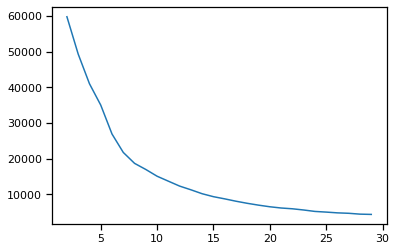

In [179]:
from sklearn.cluster import KMeans

# Finding optimal K
from sklearn.metrics import silhouette_score
witness = []
for i in range (2,30):    
    kmeans = KMeans(n_clusters=i)
    model = kmeans.fit(df)
    witness.append(model.inertia_)

plt.plot(range(2,30),witness)


In [180]:
from sklearn.metrics import silhouette_score
for i in range (2,8):    
    kmeans = KMeans(n_clusters=i)
    model = kmeans.fit(df)
    labels = model.labels_
    print(i,':',silhouette_score(df,labels))

2 : 0.46602786213195074
3 : 0.4665565202796026
4 : 0.4975561694448483
5 : 0.5536075807931287
6 : 0.54410290423254
7 : 0.5597263267559656


In [181]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
model = kmeans.fit(df)
labels = model.labels_

from sklearn.metrics import silhouette_samples
import numpy as np
X_std = np.array(df)
silhouette = silhouette_samples(X_std,labels)
import pandas
dataframe = pd.DataFrame({'label':labels,'silhouette':silhouette})

import numpy as np
print('Average Silhouette Score for Cluster 0: ',np.average(dataframe[dataframe['label'] == 0].silhouette))
print('Average Silhouette Score for Cluster 1: ',np.average(dataframe[dataframe['label'] == 1].silhouette))
print('Average Silhouette Score for Cluster 2: ',np.average(dataframe[dataframe['label'] == 2].silhouette))
print('Average Silhouette Score for Cluster 3: ',np.average(dataframe[dataframe['label'] == 3].silhouette))
print('Average Silhouette Score for Cluster 4: ',np.average(dataframe[dataframe['label'] == 4].silhouette))

from sklearn.metrics import silhouette_score
silhouette_score(X_std,labels)

Average Silhouette Score for Cluster 0:  0.43497117100257426
Average Silhouette Score for Cluster 1:  0.3518313660847849
Average Silhouette Score for Cluster 2:  0.2759057068228269
Average Silhouette Score for Cluster 3:  0.7021350674067518
Average Silhouette Score for Cluster 4:  0.10830230589174716


0.546796679284897

In [182]:
model.cluster_centers_

array([[-5.37106596e-02,  2.68005830e-01,  1.99246680e-01,
        -1.12591015e-01, -3.39718243e-01,  1.44021004e+00],
       [ 1.21421597e-01, -1.19935069e-01, -1.00163541e-01,
        -1.48791505e-01,  1.75060253e+00, -4.44449114e-01],
       [-8.49462147e-03, -2.71741323e-02, -2.35085394e-02,
         4.25486144e+00,  7.72656733e-02, -1.32347277e-01],
       [-1.07857495e-02, -1.48299472e-01, -1.17362251e-01,
        -1.73162731e-01, -4.26904063e-01, -6.94343169e-01],
       [ 1.44398967e-01,  2.47425933e+01,  2.68639191e+01,
         5.73512300e-01,  7.03751542e-01,  1.44021004e+00]])

In [183]:
df.columns

Index(['goal', 'pledged', 'backers_count', 'create_to_launch_days',
       'launch_to_deadline_days', 'state_successful'],
      dtype='object')

In [184]:
df.corr()

,goal,pledged,backers_count,create_to_launch_days,launch_to_deadline_days,state_successful
goal,1.000000,0.014778,0.005878,-0.004043,0.037430,-0.037207
pledged,0.014778,1.000000,0.746755,0.036517,0.034305,0.211251
backers_count,0.005878,0.746755,1.000000,0.030532,0.015234,0.168049
create_to_launch_days,-0.004043,0.036517,0.030532,1.000000,0.032311,0.012574
launch_to_deadline_days,0.037430,0.034305,0.015234,0.032311,1.000000,-0.115493
state_successful,-0.037207,0.211251,0.168049,0.012574,-0.115493,1.000000


In [185]:
model = KMeans(n_clusters = 5)
identified_clusters = model.fit_predict(df)
df["Cluster_int"] = identified_clusters

,goal,pledged,backers_count,create_to_launch_days,launch_to_deadline_days,state_successful,Cluster_int
0,-0.057665,-0.119100,-0.083718,0.150479,-0.377630,-0.694343,0
4,-0.068218,-0.150320,-0.112174,-0.447898,-1.708561,1.440210,1
5,-0.067406,-0.142113,-0.116020,-0.251708,2.117866,1.440210,1
6,-0.041431,-0.163012,-0.127556,-0.232090,0.204652,-0.694343,0
7,-0.068218,0.369849,1.412951,-0.447898,-0.377630,1.440210,1
...,...,...,...,...,...,...,...
15467,-0.068867,-0.164971,-0.115251,-0.457707,2.034682,-0.694343,0
15469,-0.067812,-0.170085,-0.134478,-0.457707,2.284232,-0.694343,0
15470,-0.069639,-0.170033,-0.132940,-0.457707,-0.876729,-0.694343,0
15472,-0.069436,-0.154445,-0.059106,-0.457707,0.953301,1.440210,1


In [187]:
df["Cluster_int"].value_counts()

0    7899
1    3842
3     428
2       8
4       3
Name: Cluster_int, dtype: int64